In [1]:
import argparse
import json
import numpy as np
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data

from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn import metrics
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms

import pandas as pd

from livelossplot import PlotLosses
#from skimage import transform

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"


In [4]:
def get_latest_model(rundir):
    model_list = os.listdir(rundir)
    model_list.remove('args.json')
    model_list.sort(key=lambda x:int(x.split('_')[0][5:]))
    return model_list

# 参数、模型名称

In [5]:
file_name = 'baseline'
#model_path = os.path.join(rundir, 'val0.0419_train0.0624_epoch41')
#diagnosis = 1
use_gpu = True
seed = 42
learning_rate = 1e-05
weight_decay = 0.01
epochs = 50
max_patience = 5
factor = 0.3
#part = 'axial'
rundir = '/DATA7_DB7/data/fhong/sjtuee228/'+file_name

In [6]:
training_args = {
    'rundir': rundir, 
    'seed': seed,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'epochs': epochs,
    'max_patience': max_patience,
    'factor': factor,

}

In [7]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# 导入数据

In [8]:

import random
data_path = '/DATA7_DB7/data/fhong/sjtuee228/'
INPUT_DIM = 84
MAX_PIXEL_VAL = 255
'''
MEAN = 0
STDDEV = 0
MEAN_axial = 76.5
STDDEV_axial = 60.4
MEAN_coronal = 71.1
STDDEV_coronal = 65.4
MEAN_sagittal = 65.5
STDDEV_sagittal = 49.1
'''
mean=110.211324000001
std=78.31483481542116
class Dataset(data.Dataset):
    #diagnosis = 1 abnorm
    #diagnosis = 2 meniscus
    #diagnosis = 3 acl
    def __init__(self, use_gpu, train):
        super().__init__()
        self.use_gpu = use_gpu
        #self.part = part
        self.train=train
        label_dict = {}
        self.paths = []
        
        data_path = '/DATA7_DB7/data/fhong/sjtuee228'
        if train:
            path = os.path.join(data_path, 'train_val_pseudolabeling.csv')
            data_path = os.path.join(data_path, 'train_val')
        else:
            path = os.path.join(data_path, 'val.csv')
            data_path = os.path.join(data_path, 'valid')
        
        df = pd.read_csv(path, header=0)

        for item in df['name']:
            self.paths.append(os.path.join(data_path, str(item).zfill(4)) + '.npz')

        self.labels = np.array(df.iloc[:,1])

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    def __getitem__(self, index):
        path = self.paths[index]
        vol = np.load(path)
        vox=vol['voxel']
        seg=vol['seg']
        
        vol=vox
        '''
        a=np.where(seg!=0)
        b=np.array(a,dtype=int)
        segmin=b.min()
        segmax=b.max()
        print(segmax-segmin)
        '''
        #vol=vol['voxel']
        # crop middle
        #pad = int((vol.shape[2] - INPUT_DIM)/2)
        a=0
        #if self.train:
        #    a = random.randint(0,10)
        #vol = vol[segmin:segmax,segmin:segmax,segmin:segmax]
        #transform.resize(vol,(segmax-segmin,100,100))
        
        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol)) * MAX_PIXEL_VAL
        
        '''
        if self.part == "axial":
            MEAN = MEAN_axial
            STDDEV = STDDEV_axial
        elif self.part == "coronal":
            MEAN = MEAN_coronal
            STDDEV = STDDEV_coronal
        elif self.part == "sagittal":
            MEAN = MEAN_sagittal
            STDDEV = STDDEV_sagittal
        '''
        MEAN=mean
        STDDEV=std
        # normalize
        vol = (vol - MEAN) / STDDEV
        s=0
        #if self.train:
        #    s=np.random.normal(0, 0.1, vol.shape)
        vol=vol+s
        vol=vol*seg
      
        # convert to RGB
        vol = np.stack((vol,)*3, axis=1)


        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])
        

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)
    


def load_data(use_gpu=False):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(7)
    
    train_dataset = Dataset(use_gpu, True)
    #print('train_dataset')
    #print(train_dataset[3])
    valid_dataset = Dataset(use_gpu, False)
    size_t = len(train_dataset)
    size_v = len(valid_dataset)
    #print(size_t)
    indices = list(range(size_t))
    
    np.random.shuffle(indices)
    train_indices, test_indices = indices[:], indices[:]
    
    #print('train_indices')
    #print(train_indices)
        
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    train_loader = data.DataLoader(train_dataset, batch_size=1, num_workers=8, shuffle=False, sampler=train_sampler)
    valid_loader = data.DataLoader(valid_dataset, batch_size=1, num_workers=8, shuffle=False)
    test_loader = data.DataLoader(train_dataset, batch_size=1, num_workers=8, shuffle=False, sampler=test_sampler)
    return train_loader, valid_loader, test_loader#, test_indices

# 模型

In [9]:
class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        x = self.classifier(x)
        return x
def run_model(model, loader, train=False, optimizer=None):
    preds = []
    labels = []

    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.
    num_batches = 0
    
    for batch in loader:
        if train:
            optimizer.zero_grad()

        vol, label = batch
        if loader.dataset.use_gpu:
            vol = vol.cuda()
            label = label.cuda()
        vol = Variable(vol)
        label = Variable(label)
        

        logit = model.forward(vol)

        loss = loader.dataset.weighted_loss(logit, label)
        total_loss += loss.item()

        pred = torch.sigmoid(logit)
        pred_npy = pred.data.cpu().numpy()[0][0]
        label_npy = label.data.cpu().numpy()[0][0]

        preds.append(pred_npy)
        labels.append(label_npy)

        if train:
            loss.backward()
            optimizer.step()
        num_batches += 1

    avg_loss = total_loss / num_batches

    fpr, tpr, threshold = metrics.roc_curve(labels, preds)

    if not train:
        np.save('auc.npy', np.array([fpr, tpr]))

    auc = metrics.auc(fpr, tpr)

    return avg_loss, auc, preds, labels

# train 函数

In [10]:
def train(rundir,  epochs, learning_rate, use_gpu):
    
    liveloss = PlotLosses()
    
    print('Loading data...')
    
    train_loader, valid_loader, test_loader = load_data(use_gpu)
    print(train_loader)
    
    model = MRNet()
    
    if use_gpu:
        model = model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=max_patience, factor=factor, threshold=1e-4)

    best_val_loss = float('inf')
    best_val_auc=float(0)

    start_time = datetime.now()
    
    print('Training model...')
    
    for epoch in range(epochs):
        
        logs = {}
        
        change = datetime.now() - start_time
        print('starting epoch {}. time passed: {}'.format(epoch+1, str(change)))
        
        train_loss, train_auc, _, _ = run_model(model, train_loader, train=True, optimizer=optimizer)
        print(f'train loss: {train_loss:0.4f}')
        print(f'train AUC: {train_auc:0.4f}')
        
        logs['loss'] = train_loss
        logs['auc'] = train_auc

        val_loss, val_auc, _, _ = run_model(model, valid_loader)
        print(f'valid loss: {val_loss:0.4f}')
        print(f'valid AUC: {val_auc:0.4f}')
        
        logs['val_loss'] = val_loss
        logs['val_auc'] = val_auc
        
        scheduler.step(val_loss)

        if val_auc > best_val_auc:
            best_val_auc = val_auc

            file_name = f'epoch{epoch+1}_val{val_auc:0.4f}_train{train_loss:0.4f}'
            save_path = Path(rundir) / file_name
            torch.save(model.state_dict(), save_path)
            
        liveloss.update(logs)
        liveloss.send()
    
    file_name = f'epoch{epoch+1}_val{val_loss:0.4f}_train{train_loss:0.4f}'
    save_path = Path(rundir) / file_name
    torch.save(model.state_dict(), save_path)

# evaluate function

In [11]:
def evaluate(split, model_path, use_gpu):
    print('Loading data...')
    train_loader, valid_loader, test_loader = load_data(use_gpu)
    
    print('Loading model...')
    model = MRNet()
    state_dict = torch.load(model_path, map_location=(None if use_gpu else 'cpu'))
    model.load_state_dict(state_dict)

    if use_gpu:
        model = model.cuda()

    if split == 'train':
        loader = train_loader
    elif split == 'valid':
        loader = valid_loader
    elif split == 'test':
        loader = test_loader
    else:
        raise ValueError("split must be 'train', 'valid', or 'test'")
        
    print('Running model...')
    loss, auc, preds, labels = run_model(model, loader)

    print(f'{split} loss: {loss:0.4f}')
    print(f'{split} AUC: {auc:0.4f}')

    return preds, labels

In [12]:
def get_roc(labels, preds):
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(labels, preds)
    
    plt.plot(false_positive_rate, true_positive_rate, 'b')
    
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show
    
    return thresholds

In [13]:


print(training_args)



{'rundir': '/DATA7_DB7/data/fhong/sjtuee228/baseline', 'seed': 42, 'learning_rate': 1e-05, 'weight_decay': 0.01, 'epochs': 50, 'max_patience': 5, 'factor': 0.3}


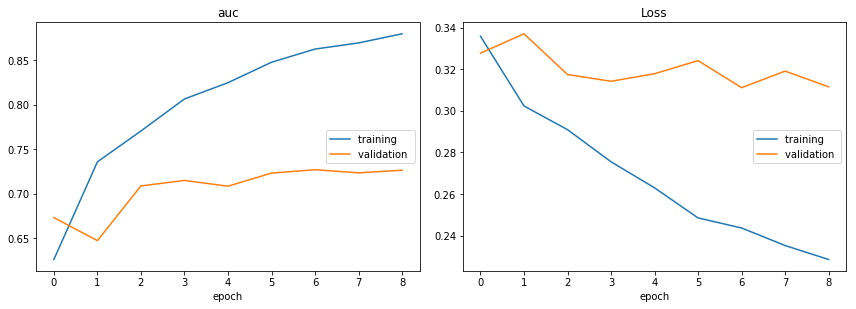

auc
	training         	 (min:    0.626, max:    0.977, cur:    0.879)
	validation       	 (min:    0.646, max:    0.740, cur:    0.726)
Loss
	training         	 (min:    0.132, max:    0.337, cur:    0.229)
	validation       	 (min:    0.304, max:    0.342, cur:    0.311)
starting epoch 10. time passed: 0:01:54.608575


KeyboardInterrupt: 

In [38]:
if use_gpu:
    torch.cuda.manual_seed_all(seed)

os.makedirs(rundir, exist_ok=True)

with open(Path(rundir) / 'args.json', 'w') as out:
    json.dump(training_args, out, indent=4)

train(rundir,epochs, learning_rate, use_gpu)